In [1]:
import numpy as np 
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
import random
import warnings
from datetime import timedelta

1. Прочитайте базу my_BRENT2019.csv и перейдите к представлению ряда первыми разностями
2. Добавьте первые разности по стоимости доллара и евро к рублю
3. сделайте ее перрасчет (ресемплинг) в представление по неделям. 
4. Постройте модель предсказания 1-й точки от текущей (h=1).

5. Сделайте вывод о поведении ошибки предсказания ряда в сравнении с прямым прогнозированием.

1. Прочитайте базу my_BRENT2019.csv и перейдите к представлению ряда первыми разностями

In [2]:
path_brent = 'my_BRENT2019.csv'
brent_data = pd.read_csv(path_brent,sep = ',', index_col=[0], parse_dates=[0])
brent_data.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0


In [3]:
full_list_date = pd.date_range(brent_data.index.min(), brent_data.index.max(), freq="D")
diff_list = set(full_list_date) - set(brent_data.index.unique())
print(f'Количество пропущенных дней: {len(diff_list)}')

Количество пропущенных дней: 621


In [4]:
full_data = pd.DataFrame(full_list_date, columns=['Date'], index=full_list_date)
full_data = full_data.join(brent_data, on='Date', how='left')
full_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3288 entries, 2010-09-01 to 2019-09-01
Freq: D
Data columns (total 12 columns):
Date               3288 non-null datetime64[ns]
Значение           2667 non-null float64
year               2667 non-null float64
month              2667 non-null float64
dayofmonth         2667 non-null float64
quarter            2667 non-null float64
dayofyear          2667 non-null float64
weekofyear         2667 non-null float64
dayofweek          2667 non-null float64
is_holiday         2667 non-null float64
is_prev_holiday    2667 non-null float64
is_next_holiday    2667 non-null float64
dtypes: datetime64[ns](1), float64(11)
memory usage: 333.9 KB


In [5]:
from datetime import timedelta
one_day = timedelta(days=1)

mas = full_data.loc[full_data['Значение'].isna(), ['Значение']].index



for i in mas:    
    min_day_value = None
    min_day = i
    while(True):
        min_day = min_day - one_day
        min_day_value = full_data.loc[min_day, ['Значение']].values[0]
        if min_day_value > 1:
            break;
            
    max_day_value = None
    max_day = i
    while(True):
        max_day = max_day + one_day
        max_day_value = full_data.loc[max_day, ['Значение']].values[0]
        if max_day_value > 1:
            break;
            
    full_data.loc[i, ['Значение']] = (max_day_value + min_day_value) / 2
    full_data.loc[i, ['year']] = i.year
    full_data.loc[i, ['month']] = i.month
    full_data.loc[i, ['dayofmonth']] = i.day
    full_data.loc[i, ['quarter']] = i.quarter
    full_data.loc[i, ['dayofyear']] = i.dayofyear
    full_data.loc[i, ['weekofyear']] = i.weekofyear
    full_data.loc[i, ['dayofweek']] = i.dayofweek
    full_data.loc[i, ['is_holiday']] = 0
    full_data.loc[i, ['is_prev_holiday']] = 0
    full_data.loc[i, ['is_next_holiday']] = 0

In [6]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3288 entries, 2010-09-01 to 2019-09-01
Freq: D
Data columns (total 12 columns):
Date               3288 non-null datetime64[ns]
Значение           3288 non-null float64
year               3288 non-null float64
month              3288 non-null float64
dayofmonth         3288 non-null float64
quarter            3288 non-null float64
dayofyear          3288 non-null float64
weekofyear         3288 non-null float64
dayofweek          3288 non-null float64
is_holiday         3288 non-null float64
is_prev_holiday    3288 non-null float64
is_next_holiday    3288 non-null float64
dtypes: datetime64[ns](1), float64(11)
memory usage: 461.9 KB


In [7]:
diff1 = np.array(full_data.iloc[1:,1].values - full_data.iloc[:-1,1].values).astype('float32') 
full_data['diff1'] = 0.0
full_data['diff1'] = full_data['diff1'].astype('float') 
full_data['diff1'].values[1:] = diff1

In [8]:
full_data.head()

,Date,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,diff1
2010-09-01,2010-09-01,76.37,2010.0,9.0,1.0,3.0,244.0,35.0,2.0,0.0,0.0,0.0,0.00
2010-09-02,2010-09-02,76.89,2010.0,9.0,2.0,3.0,245.0,35.0,3.0,0.0,0.0,0.0,0.52
2010-09-03,2010-09-03,76.57,2010.0,9.0,3.0,3.0,246.0,35.0,4.0,0.0,0.0,0.0,-0.32
2010-09-04,2010-09-04,76.62,2010.0,9.0,4.0,3.0,247.0,35.0,5.0,0.0,0.0,0.0,0.05
2010-09-05,2010-09-05,76.63,2010.0,9.0,5.0,3.0,248.0,35.0,6.0,0.0,1.0,0.0,0.01


In [9]:
full_data.columns

Index(['Date', 'Значение', 'year', 'month', 'dayofmonth', 'quarter',
       'dayofyear', 'weekofyear', 'dayofweek', 'is_holiday', 'is_prev_holiday',
       'is_next_holiday', 'diff1'],
      dtype='object')

In [10]:
brent = full_data.drop(['Date', 'year', 'month', 'dayofmonth', 'quarter',
       'dayofyear', 'weekofyear', 'dayofweek', 'is_holiday', 'is_prev_holiday',
       'is_next_holiday'], axis=1)
brent.head()

,Значение,diff1
2010-09-01,76.37,0.00
2010-09-02,76.89,0.52
2010-09-03,76.57,-0.32
2010-09-04,76.62,0.05
2010-09-05,76.63,0.01


2. Добавьте первые разности по стоимости доллара и евро к рублю

In [11]:
USD = pd.read_csv('RC_F01_09_2010_T01_09_2019_USD.csv', sep=';', index_col=[0], parse_dates=[0])
USD['curs'] = USD['curs'].str.replace(',','.',regex=True)
USD['curs'] = USD['curs'].astype('float64')

diff_list_USD = set(full_list_date) - set(USD.index.unique())
print(f'Количество пропущенных дней: {len(diff_list_USD)}')

full_date = pd.DataFrame(full_list_date, index=full_list_date)

USD = pd.concat([pd.DataFrame(full_list_date, index=full_list_date), USD], axis=1)

USD = USD.loc[USD.index <= '2019-09-01']

bufer = full_date.merge(USD)
USD = pd.DataFrame(bufer['curs'].values, index=bufer[0], columns=['curs'])

mas = USD.loc[USD['curs'].isna(), ['curs']].index

for i in mas:    
    min_day_value = None
    min_day = i
    while(True):
        min_day = min_day - one_day
        if min_day < USD.index.min():
            break;
        min_day_value = USD.loc[min_day, ['curs']].values[0]
        if min_day_value > 1:
            break;
            
    max_day_value = None
    max_day = i
    while(True):
        max_day = max_day + one_day
        if max_day > USD.index.max():
            break;
        max_day_value = USD.loc[max_day, ['curs']].values[0]
        if max_day_value > 1:
            break;
    
    if max_day_value and min_day_value:
        USD.loc[i, ['curs']] = (max_day_value + min_day_value) / 2
    elif max_day_value:
        USD.loc[i, ['curs']] = max_day_value
    elif min_day_value:
        USD.loc[i, ['curs']] = min_day_value    
        
USD.info()    
USD.head(10)

Количество пропущенных дней: 1100
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3288 entries, 2010-09-01 to 2019-09-01
Data columns (total 1 columns):
curs    3288 non-null float64
dtypes: float64(1)
memory usage: 179.4 KB


,curs
0,
2010-09-01,30.8873
2010-09-02,30.8873
2010-09-03,30.8873
2010-09-04,30.8873
2010-09-05,30.8873
2010-09-06,30.8873
2010-09-07,30.8873
2010-09-08,30.8873
2010-09-09,30.8873


In [12]:
EUR = pd.read_csv('RC_F01_09_2010_T01_09_2019_EUR.csv', sep=';', index_col=[0], parse_dates=[0])
EUR['curs'] = EUR['curs'].str.replace(',','.',regex=True)
EUR['curs'] = EUR['curs'].astype('float64')

diff_list_EUR = set(full_list_date) - set(EUR.index.unique())
print(f'Количество пропущенных дней: {len(diff_list_EUR)}')

full_date = pd.DataFrame(full_list_date, index=full_list_date)

EUR = pd.concat([pd.DataFrame(full_list_date, index=full_list_date), EUR], axis=1)

EUR = EUR.loc[EUR.index <= '2019-09-01']

bufer = full_date.merge(EUR)
EUR = pd.DataFrame(bufer['curs'].values, index=bufer[0], columns=['curs'])

mas = EUR.loc[EUR['curs'].isna(), ['curs']].index

for i in mas:    
    min_day_value = None
    min_day = i
    while(True):
        min_day = min_day - one_day
        if min_day < EUR.index.min():
            break;
        min_day_value = EUR.loc[min_day, ['curs']].values[0]
        if min_day_value > 1:
            break;
            
    max_day_value = None
    max_day = i
    while(True):
        max_day = max_day + one_day
        if max_day > EUR.index.max():
            break;
        max_day_value = EUR.loc[max_day, ['curs']].values[0]
        if max_day_value > 1:
            break;
    
    if max_day_value and min_day_value:
        EUR.loc[i, ['curs']] = (max_day_value + min_day_value) / 2
    elif max_day_value:
        EUR.loc[i, ['curs']] = max_day_value
    elif min_day_value:
        EUR.loc[i, ['curs']] = min_day_value    
        
EUR.info()    
EUR.head(10)

Количество пропущенных дней: 1100
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3288 entries, 2010-09-01 to 2019-09-01
Data columns (total 1 columns):
curs    3288 non-null float64
dtypes: float64(1)
memory usage: 179.4 KB


,curs
0,
2010-09-01,39.2948
2010-09-02,39.2948
2010-09-03,39.2948
2010-09-04,39.2948
2010-09-05,39.2948
2010-09-06,39.2948
2010-09-07,39.2948
2010-09-08,39.2948
2010-09-09,39.2948


In [13]:
brent['USD'] = USD['curs'].values
brent['EUR'] = EUR['curs'].values
brent.head()

,Значение,diff1,USD,EUR
2010-09-01,76.37,0.00,30.8873,39.2948
2010-09-02,76.89,0.52,30.8873,39.2948
2010-09-03,76.57,-0.32,30.8873,39.2948
2010-09-04,76.62,0.05,30.8873,39.2948
2010-09-05,76.63,0.01,30.8873,39.2948


In [14]:
EUR_diff1 = np.array(brent.iloc[1:,3].values - brent.iloc[:-1,3].values).astype('float32') 
USD_diff1 = np.array(brent.iloc[1:,2].values - brent.iloc[:-1,2].values).astype('float32') 

brent['EUR_diff1'] = 0.0
brent['USD_diff1'] = 0.0

brent['EUR_diff1'] = brent['EUR_diff1'].astype('float') 
brent['USD_diff1'] = brent['USD_diff1'].astype('float') 

brent['EUR_diff1'].values[1:] = EUR_diff1 
brent['USD_diff1'].values[1:] = USD_diff1 

brent.head(20)

,Значение,diff1,USD,EUR,EUR_diff1,USD_diff1
2010-09-01,76.370,0.000,30.887300,39.294800,0.000000,0.000000
2010-09-02,76.890,0.520,30.887300,39.294800,0.000000,0.000000
2010-09-03,76.570,-0.320,30.887300,39.294800,0.000000,0.000000
2010-09-04,76.620,0.050,30.887300,39.294800,0.000000,0.000000
2010-09-05,76.630,0.010,30.887300,39.294800,0.000000,0.000000
2010-09-06,76.870,0.240,30.887300,39.294800,0.000000,0.000000
2010-09-07,77.260,0.390,30.887300,39.294800,0.000000,0.000000
2010-09-08,77.930,0.670,30.887300,39.294800,0.000000,0.000000
2010-09-09,77.210,-0.720,30.887300,39.294800,0.000000,0.000000
2010-09-10,78.410,1.200,29.908600,41.671700,2.376900,-0.978700


c:\users\a.kraev\appdata\local\programs\python\python37-32\lib\site-packages\pandas\plotting\_matplotlib\converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


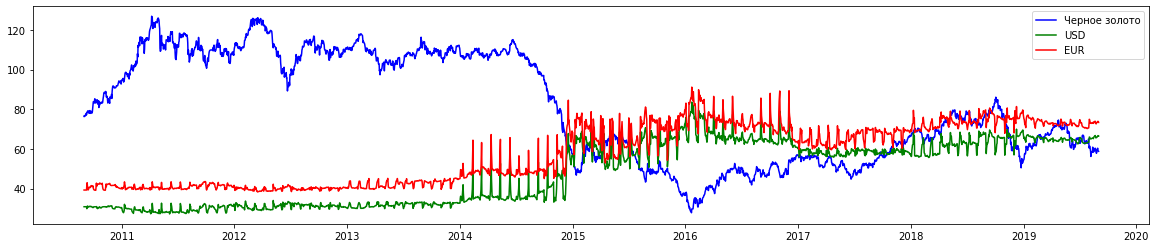

In [15]:
plt.figure(figsize =(20,4))
plt.plot(brent.index, brent['Значение'], 'b', label='Черное золото' )
plt.plot(brent.index, brent['USD'], 'g', label='USD' )
plt.plot(brent.index, brent['EUR'], 'r', label='EUR' )
plt.legend()
plt.show()

3. сделайте ее перрасчет (ресемплинг) в представление по неделям. 

In [16]:
brent_w = brent.resample('w').mean()
brent_w.head()

,Значение,diff1,USD,EUR,EUR_diff1,USD_diff1
2010-09-05,76.616000,0.052000,30.887300,39.294800,0.000000,0.000000
2010-09-12,77.830714,0.306429,30.786243,40.444043,0.282457,0.050814
2010-09-19,78.608571,-0.077857,30.889771,40.123286,-0.085064,-0.030179
2010-09-26,78.568571,0.101429,30.968896,41.009032,0.080629,-0.035971
2010-10-03,81.574286,0.678571,30.647852,40.620216,-0.254855,0.005788


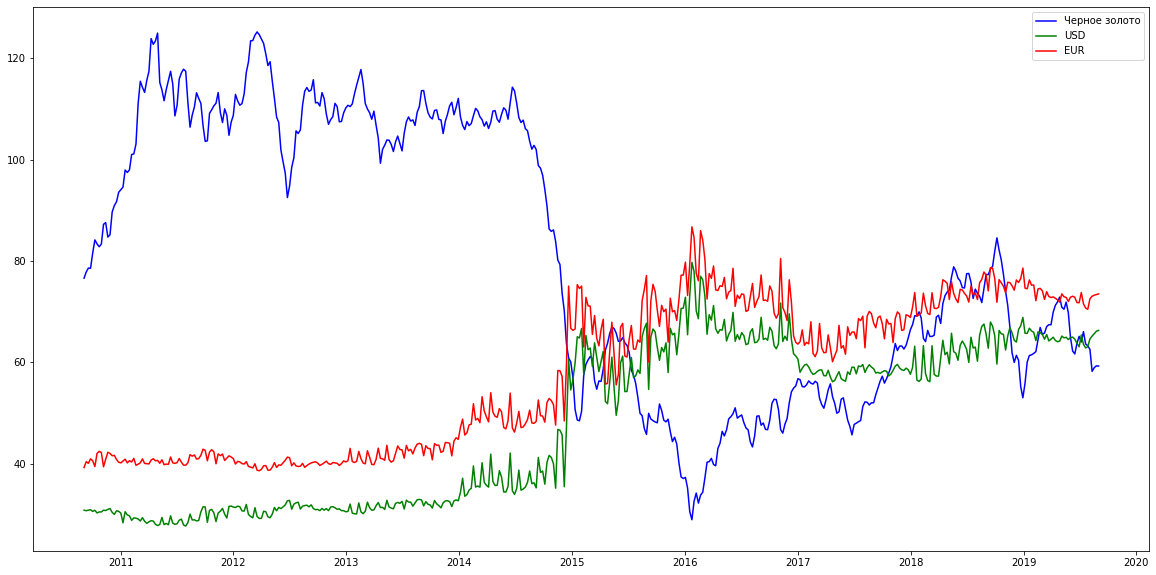

In [17]:
plt.figure(figsize =(20,10))
plt.plot(brent_w.index, brent_w['Значение'], 'b', label='Черное золото' )
plt.plot(brent_w.index, brent_w['USD'], 'g', label='USD' )
plt.plot(brent_w.index, brent_w['EUR'], 'r', label='EUR' )
plt.legend()
plt.show()

4. Постройте модель предсказания 1-й точки от текущей (h=1).

In [18]:
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import f_regression, mutual_info_regression

from sklearn.preprocessing import StandardScaler

In [19]:
scl_target=StandardScaler() 

h=1
target = brent_w['Значение'].values[h:].reshape((brent_w.shape[0]-h,1))
y = scl_target.fit_transform(target)
y.shape

(469, 1)

In [20]:
scl_x=StandardScaler() 

X = brent_w.iloc[:-h,:].values
X = scl_x.fit_transform(X.astype('float64'))
X.shape

(469, 6)

In [21]:
def split_data( data, split_date ):
    return data.loc[data.index <= split_date].copy(), \
           data.loc[data.index >  split_date].copy()

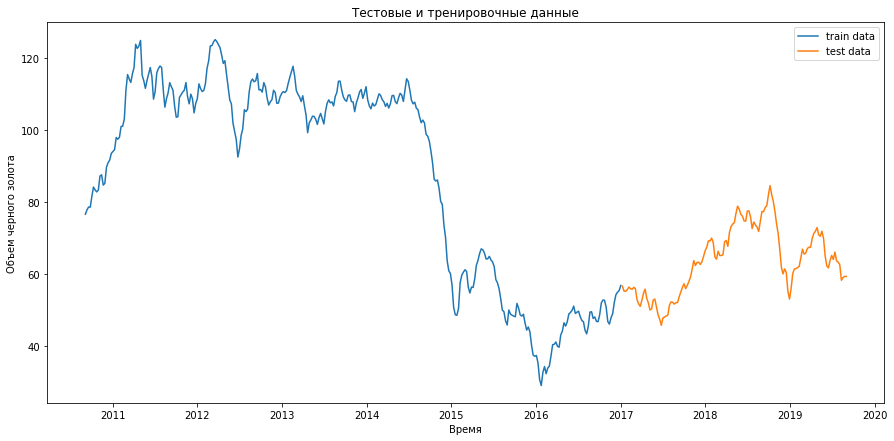

In [22]:
train, test = split_data( brent_w, '01-06-2017')

plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Объем черного золота')
plt.plot(train.index,train['Значение'], label='train data' )
plt.plot(test.index,test['Значение'], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [23]:
X_train = X[:train.shape[0],:]
y_train = y[:train.shape[0],0]
X_test = X[train.shape[0]:,:]
y_test = y[train.shape[0]:,0]

In [24]:
from sklearn.ensemble import GradientBoostingRegressor

In [25]:
model = GradientBoostingRegressor(max_depth=5, random_state=0, n_estimators=100)
model.fit( X_train, y_train )

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [26]:
y_pred = model.predict(X_test)

In [27]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

er_s = mean_squared_error(y_true=y_test, y_pred=y_pred) 
er_a = mean_absolute_error(y_true=y_test, y_pred=y_pred) 
er_r2 = r2_score(y_true=y_test, y_pred=y_pred)

print('ошибка mse :  ', er_s,'\nошибка mae  :  ', er_a,'\nоценка R2 :  ', er_r2)

ошибка mse :   0.010754612145111593 
ошибка mae  :   0.08094853029726683 
оценка R2 :   0.9091855049573908


In [28]:
y_pred_all = model.predict(X)

In [29]:
y_pred_all_nscl = scl_target.inverse_transform(y_pred_all)

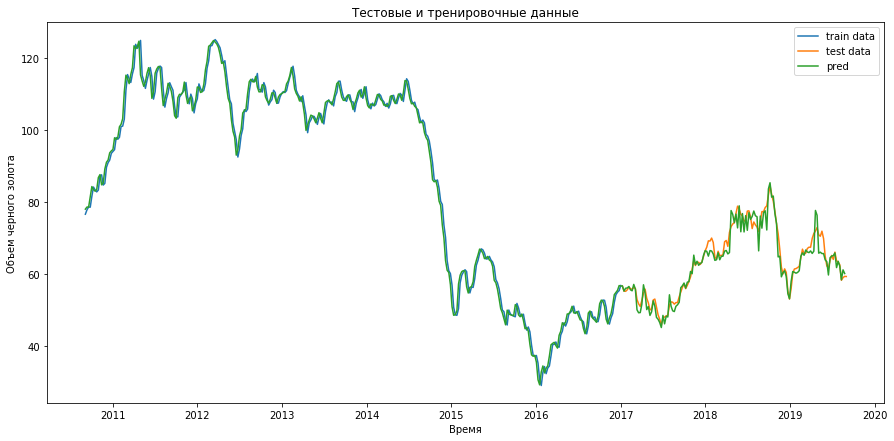

In [30]:
plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Объем черного золота')
plt.plot(train.index,train['Значение'], label='train data' )
plt.plot(test.index,test['Значение'], label='test data')
plt.plot(brent_w.iloc[:-1].index,y_pred_all_nscl, label='pred')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

5. Добавьте еще один экзогенный фактор - любой:)

In [31]:
drag = pd.read_csv('drag.csv', sep=';', index_col=[0], parse_dates=[0])

colum_data = drag.columns

full_date = pd.DataFrame(full_list_date, index=full_list_date)

drag = drag.loc[drag.index < brent_data.index.max()]
drag = drag.loc[drag.index > brent_data.index.min()]

for col in colum_data:
    drag[col] = drag[col].str.replace(',','.',regex=True)
    drag[col] = drag[col].astype('float64')

diff_list_drag = set(full_list_date) - set(drag.index.unique())
print(f'Количество пропущенных дней: {len(diff_list_drag)}')

drag = full_date.merge(drag, how='left', left_index=True, right_index=True)
drag = drag.drop([0], axis=1)


for col in colum_data:
    mas = drag.loc[drag[col].isna(), [col]].index
    for i in mas:    
        min_day_value = None
        min_day = i
        while(True):
            min_day = min_day - one_day
            if min_day < drag.index.min():
                break;
            min_day_value = drag.loc[min_day, [col]].values[0]
            if min_day_value > 1:
                break;

        max_day_value = None
        max_day = i
        while(True):
            max_day = max_day + one_day
            if max_day > drag.index.max():
                break;
            max_day_value = drag.loc[max_day, [col]].values[0]
            if max_day_value > 1:
                break;

        if max_day_value and min_day_value:
            drag.loc[i, [col]] = (max_day_value + min_day_value) / 2
        elif max_day_value:
            drag.loc[i, [col]] = max_day_value
        elif min_day_value:
            drag.loc[i, [col]] = min_day_value    
        
drag.info()    
drag.head(10)

Количество пропущенных дней: 1097
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3288 entries, 2010-09-01 to 2019-09-01
Freq: D
Data columns (total 4 columns):
Золото      3288 non-null float64
Серебро     3288 non-null float64
Платина     3288 non-null float64
Палладий    3288 non-null float64
dtypes: float64(4)
memory usage: 256.4 KB


,Золото,Серебро,Платина,Палладий
2010-09-01,1249.26,19.51,1543.20,520.36
2010-09-02,1249.26,19.51,1543.20,520.36
2010-09-03,1249.26,19.51,1543.20,520.36
2010-09-04,1249.26,19.51,1543.20,520.36
2010-09-05,1249.26,19.51,1543.20,520.36
2010-09-06,1249.26,19.51,1543.20,520.36
2010-09-07,1249.26,19.51,1543.20,520.36
2010-09-08,1249.26,19.51,1543.20,520.36
2010-09-09,1249.26,19.51,1543.20,520.36
2010-09-10,1279.39,22.48,1623.15,552.91


In [32]:
brent_drag = brent.copy()

In [33]:
brent_drag['Gold'] = drag['Золото'].values
brent_drag['Silver'] = drag['Серебро'].values
brent_drag['Platinum'] = drag['Платина'].values
brent_drag['Palladium'] = drag['Палладий'].values
brent_drag.head()

,Значение,diff1,USD,EUR,EUR_diff1,USD_diff1,Gold,Silver,Platinum,Palladium
2010-09-01,76.37,0.00,30.8873,39.2948,0.0,0.0,1249.26,19.51,1543.2,520.36
2010-09-02,76.89,0.52,30.8873,39.2948,0.0,0.0,1249.26,19.51,1543.2,520.36
2010-09-03,76.57,-0.32,30.8873,39.2948,0.0,0.0,1249.26,19.51,1543.2,520.36
2010-09-04,76.62,0.05,30.8873,39.2948,0.0,0.0,1249.26,19.51,1543.2,520.36
2010-09-05,76.63,0.01,30.8873,39.2948,0.0,0.0,1249.26,19.51,1543.2,520.36


In [34]:
Gold_diff1 = np.array(brent_drag.iloc[1:,6].values - brent_drag.iloc[:-1,6].values).astype('float32') 
Silver_diff1 = np.array(brent_drag.iloc[1:,7].values - brent_drag.iloc[:-1,7].values).astype('float32') 
Platinum_diff1 = np.array(brent_drag.iloc[1:,8].values - brent_drag.iloc[:-1,8].values).astype('float32') 
Palladium_diff1 = np.array(brent_drag.iloc[1:,9].values - brent_drag.iloc[:-1,9].values).astype('float32') 

brent_drag['Gold_diff1'] = 0.0
brent_drag['Silver_diff1'] = 0.0
brent_drag['Platinum_diff1'] = 0.0
brent_drag['Palladium_diff1'] = 0.0

brent_drag['Gold_diff1'] = brent_drag['Gold_diff1'].astype('float') 
brent_drag['Silver_diff1'] = brent_drag['Silver_diff1'].astype('float') 
brent_drag['Platinum_diff1'] = brent_drag['Platinum_diff1'].astype('float') 
brent_drag['USD_diff1'] = brent_drag['USD_diff1'].astype('float')

brent_drag['Gold_diff1'].values[1:] = Gold_diff1 
brent_drag['Silver_diff1'].values[1:] = Silver_diff1 
brent_drag['Platinum_diff1'].values[1:] = Platinum_diff1 
brent_drag['Palladium_diff1'].values[1:] = Palladium_diff1 

brent_drag.head(20)

,Значение,diff1,USD,EUR,EUR_diff1,USD_diff1,Gold,Silver,Platinum,Palladium,Gold_diff1,Silver_diff1,Platinum_diff1,Palladium_diff1
2010-09-01,76.370,0.000,30.887300,39.294800,0.000000,0.000000,1249.26,19.510,1543.2000,520.3600,0.000000,0.000,0.000000,0.000000
2010-09-02,76.890,0.520,30.887300,39.294800,0.000000,0.000000,1249.26,19.510,1543.2000,520.3600,0.000000,0.000,0.000000,0.000000
2010-09-03,76.570,-0.320,30.887300,39.294800,0.000000,0.000000,1249.26,19.510,1543.2000,520.3600,0.000000,0.000,0.000000,0.000000
2010-09-04,76.620,0.050,30.887300,39.294800,0.000000,0.000000,1249.26,19.510,1543.2000,520.3600,0.000000,0.000,0.000000,0.000000
2010-09-05,76.630,0.010,30.887300,39.294800,0.000000,0.000000,1249.26,19.510,1543.2000,520.3600,0.000000,0.000,0.000000,0.000000
2010-09-06,76.870,0.240,30.887300,39.294800,0.000000,0.000000,1249.26,19.510,1543.2000,520.3600,0.000000,0.000,0.000000,0.000000
2010-09-07,77.260,0.390,30.887300,39.294800,0.000000,0.000000,1249.26,19.510,1543.2000,520.3600,0.000000,0.000,0.000000,0.000000
2010-09-08,77.930,0.670,30.887300,39.294800,0.000000,0.000000,1249.26,19.510,1543.2000,520.3600,0.000000,0.000,0.000000,0.000000
2010-09-09,77.210,-0.720,30.887300,39.294800,0.000000,0.000000,1249.26,19.510,1543.2000,520.3600,0.000000,0.000,0.000000,0.000000
2010-09-10,78.410,1.200,29.908600,41.671700,2.376900,-0.978700,1279.39,22.480,1623.1500,552.9100,30.129999,2.970,79.949997,32.549999


In [35]:
brent_drag_w = brent_drag.resample('w').mean()
brent_drag_w.head()

,Значение,diff1,USD,EUR,EUR_diff1,USD_diff1,Gold,Silver,Platinum,Palladium,Gold_diff1,Silver_diff1,Platinum_diff1,Palladium_diff1
2010-09-05,76.616000,0.052000,30.887300,39.294800,0.000000,0.000000,1249.260000,19.510000,1543.200000,520.360000,0.000000,0.000000,0.000000,0.000000
2010-09-12,77.830714,0.306429,30.786243,40.444043,0.282457,0.050814,1293.465714,22.435714,1603.794286,579.147143,21.714286,1.590000,21.480000,31.421428
2010-09-19,78.608571,-0.077857,30.889771,40.123286,-0.085064,-0.030179,1265.598571,20.915000,1583.533571,553.372857,-17.620000,-1.411429,-10.900714,-27.580714
2010-09-26,78.568571,0.101429,30.968896,41.009032,0.080629,-0.035971,1282.827143,20.869286,1622.498214,542.943929,0.957143,0.032857,1.096429,0.637143
2010-10-03,81.574286,0.678571,30.647852,40.620216,-0.254855,0.005788,1240.045893,19.895179,1572.635179,523.120893,-16.172322,-0.436607,-16.714464,-10.575536


In [36]:
brent_drag_w = brent_drag_w.drop(['USD', 'EUR', 'EUR_diff1', 'USD_diff1'], axis=1)
brent_drag_w.head()

,Значение,diff1,Gold,Silver,Platinum,Palladium,Gold_diff1,Silver_diff1,Platinum_diff1,Palladium_diff1
2010-09-05,76.616000,0.052000,1249.260000,19.510000,1543.200000,520.360000,0.000000,0.000000,0.000000,0.000000
2010-09-12,77.830714,0.306429,1293.465714,22.435714,1603.794286,579.147143,21.714286,1.590000,21.480000,31.421428
2010-09-19,78.608571,-0.077857,1265.598571,20.915000,1583.533571,553.372857,-17.620000,-1.411429,-10.900714,-27.580714
2010-09-26,78.568571,0.101429,1282.827143,20.869286,1622.498214,542.943929,0.957143,0.032857,1.096429,0.637143
2010-10-03,81.574286,0.678571,1240.045893,19.895179,1572.635179,523.120893,-16.172322,-0.436607,-16.714464,-10.575536


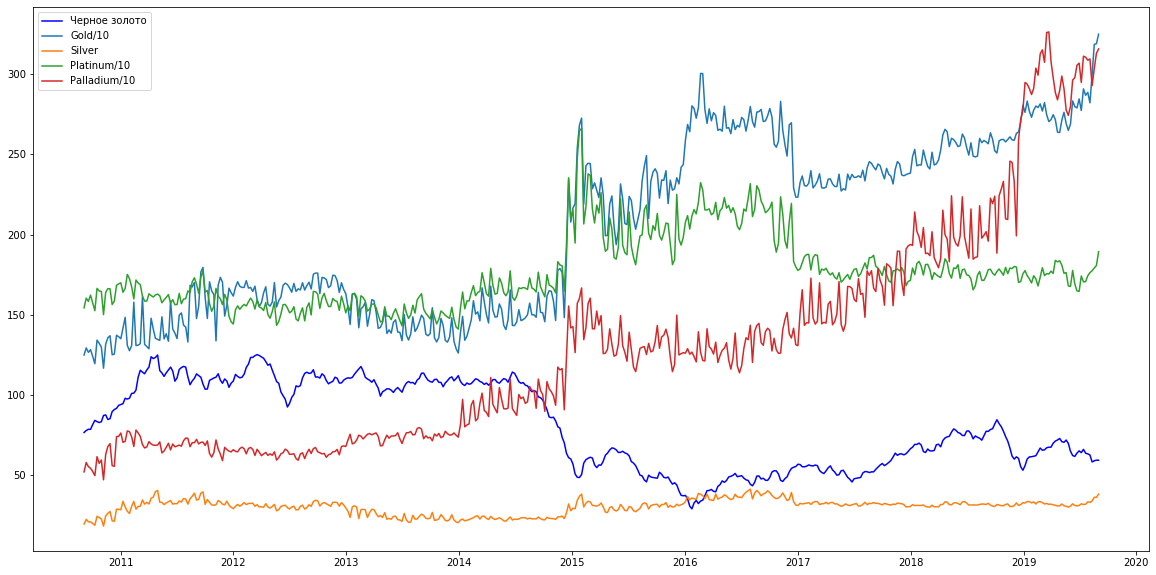

In [42]:
plt.figure(figsize =(20,10))
plt.plot(brent_drag_w.index, brent_drag_w['Значение'], 'b', label='Черное золото' )
plt.plot(brent_drag_w.index, brent_drag_w['Gold']/10, label='Gold/10' )
plt.plot(brent_drag_w.index, brent_drag_w['Silver'], label='Silver' )
plt.plot(brent_drag_w.index, brent_drag_w['Platinum']/10, label='Platinum/10' )
plt.plot(brent_drag_w.index, brent_drag_w['Palladium']/10, label='Palladium/10' )
plt.legend()
plt.show()

In [38]:
scl_target=StandardScaler() 

target = brent_drag_w['Значение'].values[h:].reshape((brent_drag_w.shape[0]-h,1))
y = scl_target.fit_transform(target)
y.shape

scl_x=StandardScaler() 

X = brent_drag_w.iloc[:-h,:].values
X = scl_x.fit_transform(X.astype('float64'))
X.shape

X_train = X[:train.shape[0],:]
y_train = y[:train.shape[0],0]
X_test = X[train.shape[0]:,:]
y_test = y[train.shape[0]:,0]

model = GradientBoostingRegressor(max_depth=5, random_state=0, n_estimators=100)
model.fit( X_train, y_train )

y_pred = model.predict(X_test)

er_s = mean_squared_error(y_true=y_test, y_pred=y_pred) 
er_a = mean_absolute_error(y_true=y_test, y_pred=y_pred) 
er_r2 = r2_score(y_true=y_test, y_pred=y_pred)

print('ошибка mse :  ', er_s,'\nошибка mae  :  ', er_a,'\nоценка R2 :  ', er_r2)

ошибка mse :   0.012715624911574679 
ошибка mae  :   0.08554526979774095 
оценка R2 :   0.8926262481701153


In [39]:
y_pred_all = model.predict(X)
y_pred_all_nscl = scl_target.inverse_transform(y_pred_all)

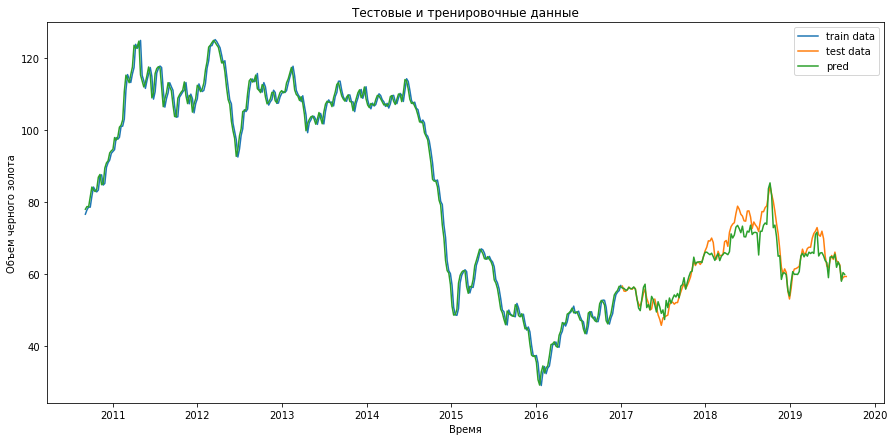

In [40]:
plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Объем черного золота')
plt.plot(train.index,train['Значение'], label='train data' )
plt.plot(test.index,test['Значение'], label='test data')
plt.plot(brent_w.iloc[:-1].index,y_pred_all_nscl, label='pred')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

6. Сравните модель с дополнительным экзогенным фактором и исходную и сделайте вывод о поведении ошибки предсказания ряда в сравнении с прямым прогнозированием.

На 2ой модели увеличилась ошибка значит цена драгоценных металлов мене влиятельна на цену нефти, чем бумажки.